In [1]:
import sys
sys.path.append('../')

from model import *
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import pickle as pkl
import matplotlib.pyplot as plt
import sklearn
import numpy as np

### Data

In [51]:
with open('../../../data/ChildWelfare/X_preprocess.pkl', 'rb') as handle:
    X,screener_ids,refer_ids,Y_obs,D,Y_serv,Y_sub,colnames = pkl.load(handle)

In [52]:
X.shape

(46544, 216)

In [53]:
#intercept column
X = np.append(X,np.ones((X.shape[0],1)),axis=1)
#X.shape

In [54]:
#drop instances if expert assessed a single case

drop_experts = []
for num in screener_ids:

    if screener_ids.count(num) < 10:

        drop_experts.append(num)

In [55]:
drop_idx = []
for index, elem in enumerate(screener_ids):
    if elem in drop_experts:
        drop_idx.append(index)

In [56]:
X = np.delete(X,drop_idx,axis=0)
Y_serv = np.delete(Y_serv,drop_idx,axis=0)
Y_sub = np.delete(Y_sub,drop_idx,axis=0)
Y_obs = np.delete(Y_obs,drop_idx,axis=0)
D = np.delete(D,drop_idx,axis=0)
refer_ids = np.delete(refer_ids,drop_idx,axis=0)
screener_ids = np.delete(screener_ids,drop_idx,axis=0)

In [57]:
Y_obs.shape

(46528, 1)

In [58]:
D = D.reshape((D.shape[0],))
Y_obs = Y_obs.reshape((Y_obs.shape[0],))

In [59]:
target = pd.DataFrame({'D': D, 'Y1': Y_obs, 'Y2': Y_serv, 'Y3': Y_sub})

Split data in a 80% train, 20% test

In [60]:
cov_train, cov_test, tar_train, tar_test, nur_train, nur_test = train_test_split(pd.DataFrame(X), target, pd.Series(screener_ids), test_size = 0.2, random_state = 42)

### Modelling

In [61]:
# Model's characteristics
params = {'layers': []} # If = [] equivalent to a simple logistic regression

# Amalgation parameters
rho = 0.05 # Control which point to consider from a confience point of view
pi_1 = 4.0 # Control criterion on centre mass metric
pi_2 = 0.8 # Control criterion on opposing metric
tau = 1.0  # Balance between observed and expert labels

##### 1. Train on decision

This model models the nurse decision based on covariates

In [62]:
for l1_penalty in [ 0.001, 1.0]:
    try:
        model = BinaryMLP(**params)
        model = model.fit(cov_train, tar_train['D'], nur_train, l1_penalty = l1_penalty)
        break
    except Exception as e:
        print(e, l1_penalty)
        pass

  0%|          | 0/1 [00:00<?, ?it/s]

Architecture leads to singular weights matrix for last layer: Use another architecture or increase l1_penalty. 0.001


Loss: 0.693: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Architecture leads to singular weights matrix for last layer: Use another architecture or increase l1_penalty. 1.0


In [63]:
Y_pred_h_test = model.predict(cov_test)

In [64]:
# Naive performance
roc_auc_score(tar_test['Y1'], model.predict(cov_test))

0.5975724660776869

In [65]:
# Yc performance
roc_auc_score(tar_test['Y2'], model.predict(cov_test))

0.5829947342241497

In [66]:
roc_auc_score(tar_test['Y3'], model.predict(cov_test))

0.5730738759443709

In [67]:
roc_auc_score(tar_test['D'], model.predict(cov_test))

0.5663284199933506

##### 2. Agreement computation 

Measure of agreeability are estimated in a cross validation fashion on the train set.

In [68]:
# Fold evaluation of influences
folds, predictions, influence = influence_cv(BinaryMLP, cov_train, tar_train['D'], nur_train, params = params)

Loss: 0.609: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


ValueError: Architecture leads to singular weights matrix for last layer: Use another architecture or increase l1_penalty.

In [ ]:
# Compute metrics agreeability
center_metric, opposing_metric = compute_agreeability(influence)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(center_metric, opposing_metric)

In [ ]:
# Apply criteria on amalgamation
high_conf = (predictions > (1 - rho)) | (predictions < rho)
high_agr = (center_metric > pi_1) & (opposing_metric > pi_2) & high_conf
high_agr_correct = ((predictions - tar_train['D']).abs() < rho) & high_agr

In [ ]:
plt.hist(predictions)

In [ ]:
print('high_conf:', sum(high_conf))
print('high_agr:', sum(high_agr))
print('high_agr_correct:', sum(high_agr_correct))

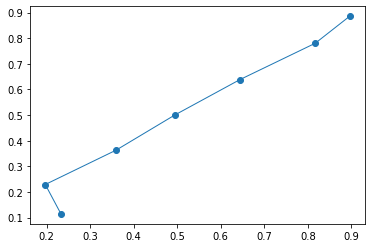

In [62]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(tar_train['D'], predictions, n_bins=7)
plt.plot(prob_true,prob_pred, marker='o', linewidth=1, label='logreg')


In [63]:
# Create amalgamated labels
tar_train['Ya'] = tar_train['Y1'].copy()
tar_train['Ya'][high_agr_correct] = (1 - tau) * tar_train['Y1'][high_agr_correct] \
                                    + tau * tar_train['D'][high_agr_correct]

In [64]:
sum(tar_train['D']!=tar_train['Y1'])

18248

In [26]:
sum(tar_train['Ya']!=tar_train['Y1'])

0

In [27]:
#index for selective labels
index_amalg = [i==1.0 for i in tar_train['D']] | high_agr_correct

##### 3. Updated model

In [28]:
#model with selective labels
model = BinaryMLP(**params)
model = model.fit(cov_train[index_amalg], tar_train[index_amalg]['Ya'], nur_train[index_amalg])

Loss: 0.616: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


In [29]:
Y_pred_amalg_test = model.predict(cov_test)

In [30]:
# #model without selective labels
# model = BinaryMLP(**params)
# model = model.fit(cov_train, tar_train['Ya'], nur_train[index_amalg])

In [31]:
# Naive performance
roc_auc_score(tar_test['Y1'], model.predict(cov_test))

0.5226490203625818

In [32]:
# Yc performance
roc_auc_score(tar_test['Y2'],model.predict(cov_test))

0.3356237156879399

In [33]:
roc_auc_score(tar_test['Y3'],model.predict(cov_test))

0.32043971907084967

In [34]:
roc_auc_score(tar_test['D'],model.predict(cov_test))

0.32681817018036524

##### 4. Train on observed data

In [35]:
model = BinaryMLP(**params)
model = model.fit(cov_train[tar_train['D']==1], tar_train['Y1'][tar_train['D']==1], nur_train)

Loss: 0.616: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


In [36]:
Y_pred_obs_test = model.predict(cov_test)

In [37]:
# Naive performance
roc_auc_score(tar_test['Y1'], model.predict(cov_test))

0.5226490203625818

In [38]:
# Yc performance
roc_auc_score(tar_test['Y2'],model.predict(cov_test))

0.3356237156879399

In [39]:
roc_auc_score(tar_test['Y3'],model.predict(cov_test))

0.32043971907084967

In [40]:
roc_auc_score(tar_test['D'],model.predict(cov_test))

0.32681817018036524

## Precision/Accuracy

In [41]:
def eval_pred_outcome(Y_outcome_test, Y_pred_test, Y_h_test):
    Y_pred_test_scrin = Y_pred_test[Y_h_test==1]
    Y_outcome_test_scrin = Y_outcome_test[Y_h_test==1]
    #print(sum(Y_outcome_test_scrin))
    idx_25qrtl_pred = np.argsort(Y_pred_test_scrin)[::-1][:int(np.floor(p*len(Y_pred_test_scrin)))]
    #baseline
    baseline = sum(Y_outcome_test_scrin)/len(Y_outcome_test_scrin)
    #print(idx_25qrtl_pred )
    #print(sum(Y_outcome_test_scrin[idx_25qrtl_pred]))
    #precision and recall in top p% highsest scored screen-in
    precision_p = sum(Y_outcome_test_scrin[idx_25qrtl_pred])/len(idx_25qrtl_pred)
    recall_p = sum(Y_outcome_test_scrin[idx_25qrtl_pred])/sum(Y_outcome_test)
    
    return baseline, precision_p, recall_p

In [43]:
p=0.25
print('Eval resp. Y_obs')
print('f_y', eval_pred_outcome(np.array(tar_test['Y1']).flatten(), Y_pred_obs_test.flatten(), np.array(tar_test['D']==1).flatten()))
print('f_A', eval_pred_outcome(np.array(tar_test['Y1']).flatten(), Y_pred_amalg_test.flatten(), np.array(tar_test['D']==1).flatten()))
print('f_h', eval_pred_outcome(np.array(tar_test['Y1']).flatten(), Y_pred_h_test.flatten(), np.array(tar_test['D']==1).flatten()))

Eval resp. Y_obs
f_y (0.11727896649172385, 0.16155088852988692, 0.2617801047120419)
f_A (0.11727896649172385, 0.16155088852988692, 0.2617801047120419)
f_h (0.11727896649172385, 0.1704361873990307, 0.2761780104712042)


In [44]:
print('Eval resp. Y_serv')
print('f_y', eval_pred_outcome(np.array(tar_test['Y2']).flatten(), Y_pred_obs_test.flatten(), np.array(tar_test['D']==1).flatten()))
print('f_A', eval_pred_outcome(np.array(tar_test['Y2']).flatten(), Y_pred_amalg_test.flatten(), np.array(tar_test['D']==1).flatten()))
print('f_h', eval_pred_outcome(np.array(tar_test['Y2']).flatten(), Y_pred_h_test.flatten(), np.array(tar_test['D']==1).flatten()))

Eval resp. Y_serv
f_y (0.4152200242228502, 0.3554119547657512, 0.21390374331550802)
f_A (0.4152200242228502, 0.3554119547657512, 0.21390374331550802)
f_h (0.4152200242228502, 0.6195476575121163, 0.37287311618862423)


In [45]:
print('Eval resp. Y_sub')
print('f_y', eval_pred_outcome(np.array(tar_test['Y2']).flatten(), Y_pred_obs_test.flatten(), np.array(tar_test['D']==1).flatten()))
print('f_A', eval_pred_outcome(np.array(tar_test['Y2']).flatten(), Y_pred_amalg_test.flatten(), np.array(tar_test['D']==1).flatten()))
print('f_h', eval_pred_outcome(np.array(tar_test['Y2']).flatten(), Y_pred_h_test.flatten(), np.array(tar_test['D']==1).flatten()))

Eval resp. Y_sub
f_y (0.4152200242228502, 0.3554119547657512, 0.21390374331550802)
f_A (0.4152200242228502, 0.3554119547657512, 0.21390374331550802)
f_h (0.4152200242228502, 0.6195476575121163, 0.37287311618862423)


In [ ]:
def eval_pred(Y_pred_test, Y_h, Y_ooh, Y_serv, Y_sub, refer_ids_test, refer_ids, p):
    #identify test sets
    dic_k_Y_pred = {}
    Y_h_test = np.array(Y_h[[(r in refer_ids_test) for r in refer_ids]])
    Y_h_test = np.transpose(Y_h_test)[0]
    
    #Y_pred for subset of cases that were actually screened-in
    Y_pred_test_scrin = Y_pred_test[Y_h_test==1]
    #top p% highest scored screened-in cases 
    idx_25qrtl_pred = np.argsort(Y_pred_test_scrin)[::-1][:int(np.floor(p*len(Y_pred_test_scrin)))]
    print('done with pre proc')
    base_ooh, precision_ooh, recall_ooh = eval_pred_outcome(idx_25qrtl_pred, Y_ooh, Y_h_test, refer_ids_test, refer_ids)
    print('done with ooh')
    base_serv, precision_serv, recall_serv = eval_pred_outcome(idx_25qrtl_pred, Y_serv, Y_h_test, refer_ids_test, refer_ids)
    base_sub, precision_sub, recall_sub = eval_pred_outcome(idx_25qrtl_pred, Y_sub, Y_h_test, refer_ids_test, refer_ids)
    
    dic_k_Y_pred['ooh'] = {'base': float(base_ooh), 'precision': float(precision_ooh), 'recall': float(recall_ooh)}
    print('done with dic ooh')
    dic_k_Y_pred['sub'] = {'base': float(base_sub), 'precision': float(precision_sub), 'recall': float(recall_sub)}
    dic_k_Y_pred['serv'] = {'base': float(base_serv), 'precision': float(precision_serv), 'recall': float(recall_serv)}
    
    return dic_k_Y_pred
    

In [ ]:
def eval_k_iter(M_results, Y_h, Y_ooh, Y_serv, Y_sub, p):
    K = len(M_results)
    dic_eval = {}
    
    for k in np.arange(K):
        dic_k = {}
        Y_pred_hybrid_test, Y_pred_obs_test, Y_pred_amalg_test, Y_pred_h_test, refer_ids_train, refer_ids_test = M_results[k]
        dic_k['Y_pred_obs_test'] = eval_pred(Y_pred_obs_test, Y_h, Y_ooh, Y_serv, Y_sub, refer_ids_test, refer_ids, p)
        print('done with Y_pred_obs_test')
        dic_k['Y_pred_h_test'] = eval_pred(Y_pred_h_test, Y_h, Y_ooh, Y_serv, Y_sub, refer_ids_test, refer_ids, p)
        print('done with Y_pred_h_test')
        dic_k['Y_pred_hybrid_test'] = eval_pred(Y_pred_hybrid_test, Y_h, Y_ooh, Y_serv, Y_sub, refer_ids_test, refer_ids, p)
        print('done with Y_pred_hyb_test')
        dic_k['Y_pred_amalg_test'] = eval_pred(Y_pred_amalg_test, Y_h, Y_ooh, Y_serv, Y_sub, refer_ids_test, refer_ids, p)
    
    
        dic_eval[k] = dic_k
    
    return dic_eval

In [ ]:
def plot_perf_bar(dic_eval, models = ['Y_pred_obs_test', 'Y_pred_h_test',
                                     'Y_pred_hybrid_test', 'Y_pred_amalg_test'], 
                  plot_labels = [ '$f_y$', '$f_h$', '$f_\mathcal{hyb}$',  '$f_\mathcal{A}$' ] ,
                  labels = ['ooh', 'sub', 'serv'], y_max=1.05, legend_appear=True,
                  metric ='precision', fig_title='fig_noname'):
    
    K = len(dic_eval.keys())
    
    n_labels = len(labels)
    
    fig, ax = plt.subplots(figsize=(10,5))
    index = np.arange(n_labels)
    bar_width = 0.15
    opacity = 0.8
    colors = ['green', 'darkred', 'yellow', 'blue']
    hatches = ['//', '-', '\\', '.']
    
    
    m_idx =0
    for m in models:
        plot_mean = [0]*n_labels
        plot_std = [0]*n_labels
        
        l_idx = 0
        for l in labels:
            metric_list = [0]*K
            if metric == 'precision':
                for k in range(K):
                    metric_list[k] = dic_eval[k][m][l]['precision']
            
            if metric == 'recall':
                for k in range(K):
                    metric_list[k] = dic_eval[k][m][l]['recall']
            plot_mean[l_idx] = np.mean(metric_list)  
            plot_std[l_idx] = np.std(metric_list)  
            l_idx += 1
        rects = plt.bar(index+m_idx*bar_width, plot_mean, yerr= plot_std,
            alpha=opacity, color=colors[m_idx], capsize=7,  width=.1, hatch = hatches[m_idx],
                            label=plot_labels[m_idx])        
            
            
        m_idx+=1                
    
    
    for n in index[:-1]:
        if metric=='precision':
            t= 0.8
        else:
            t=0.7
        plt.axvline(x=n+t, color='grey', linestyle='--')
        
    if metric=='precision':
        plot_mean = [0]*n_labels
        plot_std = [0]*n_labels
        l_idx = 0
        for l in labels:
            metric_list = [0]*K
            for k in range(K):
                metric_list[k] = dic_eval[k][m][l]['base']
            plot_mean[l_idx] = np.mean(metric_list)  
            plot_std[l_idx] = np.std(metric_list) 
            l_idx +=1
        rects = plt.bar(index+len(models)*bar_width, plot_mean, yerr= plot_std,
            alpha=opacity, color='grey',capsize=7,  width=.1,label='Overall prev.')     

    plt.ylabel(metric,fontsize=25)
    #plt.ylim((0,1.05))
    #plt.title('Performance of outcomes by model',fontsize=18)
    plt.xticks(index + 1.5*bar_width, ('OOH', 'Substantiated', 'Services'),fontsize=18)
    plt.yticks(fontsize=16)
    if legend_appear==True:
        plt.legend(loc = 'upper left', fontsize=18)
    plt.ylim(0.0,y_max)
    plt.tight_layout()

#     plt.savefig(fig_title, dpi=300,
#             orientation='portrait' )
    plt.show()